# Viver sem grandes superfícies

Extrair preços de produtos nas grandes superfícies

Manuel Banza - April, 2023

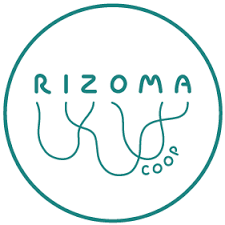

In [22]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import io
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

In [2]:
# Show all columns with head()
pd.set_option('display.max_columns', None)

# 1. Importar dados

## 1.1. Lista de produtos a pesquisar

In [4]:
# url = 'https://docs.google.com/spreadsheets/d/1ZGw9064Dj07dKZbKxFUNQVBYS9fDPWhbTLwE0pfjXK4/edit?usp=sharing'

In [5]:
SHEET_ID = '1ZGw9064Dj07dKZbKxFUNQVBYS9fDPWhbTLwE0pfjXK4'
SHEET_NAME = 'Folha1'
url = f'https://docs.google.com/spreadsheets/d/{SHEET_ID}/gviz/tq?tqx=out:csv&sheet={SHEET_NAME}'
df = pd.read_csv(url)
df.head()

,Palavras a pesquisar
0,manteiga de amendoim
1,leite de soja
2,cogumelos marron


In [6]:
keywords = df['Palavras a pesquisar'].to_list()

In [8]:
keywords[1]

'leite de soja'

# 2. Obter dados

In [9]:
%%time

# Scrapper

import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

# disable SSL certificate verification warnings
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

url = "https://content-api.prices-crawler.duckdns.org/api/v1/products/search"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/112.0",
    "Accept": "application/json, text/plain, */*",
    "Accept-Language": "pt-PT,pt;q=0.8,en;q=0.5,en-US;q=0.3",
    "Accept-Encoding": "gzip, deflate, br",
    "Content-Type": "application/json",
    "Origin": "https://prices-crawler.vercel.app",
    "Connection": "keep-alive",
    "Referer": "https://prices-crawler.vercel.app/",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "cross-site",
}

json_data = []

for keyword in keywords:
    data = {
        "catalogs": ["pt.auchan", "pt.continente", "pt.minipreco", "pt.pingo-doce"],
        "query": keyword,
    
    }

    response = requests.post(url, headers=headers, json=data, verify=False)

    if response.ok:
        response_data = response.json()
        # append a dictionary with the keyword value to json_data
        json_data.append({"keyword": keyword, "response": response_data})
    else:
        print(f"API request failed with status code {response.status_code}")


CPU times: user 86.8 ms, sys: 933 µs, total: 87.7 ms
Wall time: 9.05 s


In [50]:
#json_data

In [15]:
# define the columns for the dataframe
columns = ['keyword', 'locale', 'catalog', 'id', 'reference', 'name', 'regularPrice', 'campaignPrice', 'pricePerQuantity', 'quantity', 'brand', 'description', 'productUrl', 'imageUrl', 'eanUpcList', 'date', 'data']

# create an empty list to hold each row of data
data = []

for dictionary in json_data:
    response = dictionary['response']
    locale = response[0]['locale']
    for catalog_data in response:
        catalog = catalog_data['catalog']
        for product in catalog_data['products']:
            # add the relevant data to the 'data' list
            data.append([
                dictionary['keyword'], locale, catalog, product.get('id'), product.get('reference'), product.get('name'),
                product.get('regularPrice'), product.get('campaignPrice'), product.get('pricePerQuantity'), product.get('quantity'),
                product.get('brand'), product.get('description'), product.get('productUrl'), product.get('imageUrl'),
                product.get('eanUpcList'), product.get('date'), product.get('data')
            ])

# create the Pandas dataframe
df = pd.DataFrame(data, columns=columns)


In [16]:
df.head()

,keyword,locale,catalog,id,reference,name,regularPrice,campaignPrice,pricePerQuantity,quantity,brand,description,productUrl,imageUrl,eanUpcList,date,data
0,manteiga de amendoim,pt,auchan,pt.auchan.3503408,3503408,manteiga amendoim auchan 100% & cremosa 500g,"2,89 €",None,5.78 €/Kg,None,None,None,https://www.auchan.pt/pt/alimentacao/mercearia...,https://www.auchan.pt/dw/image/v2/BFRC_PRD/on/...,None,2023-04-16T10:42:55.020124996Z,None
1,manteiga de amendoim,pt,auchan,pt.auchan.2485760,2485760,manteiga prozis amendoim crocante 1kg,"5,99 €",None,5.99 €/Kg,None,None,None,https://www.auchan.pt/pt/biologicos-e-escolhas...,https://www.auchan.pt/dw/image/v2/BFRC_PRD/on/...,None,2023-04-16T10:42:55.020124996Z,None
2,manteiga de amendoim,pt,auchan,pt.auchan.2271335,2271335,manteiga prozis amendoim crocante e 100% natur...,"3,49 €",None,6.98 €/Kg,None,None,None,https://www.auchan.pt/pt/biologicos-e-escolhas...,https://www.auchan.pt/dw/image/v2/BFRC_PRD/on/...,None,2023-04-16T10:42:55.020124996Z,None
3,manteiga de amendoim,pt,auchan,pt.auchan.3209072,3209072,iogurte yopro manteiga amendoim e banana 160g,"1,64 €","1,29 €",8.06 €/Kg,None,None,None,https://www.auchan.pt/pt/alimentacao/produtos-...,https://www.auchan.pt/dw/image/v2/BFRC_PRD/on/...,None,2023-04-16T10:42:55.020124996Z,None
4,manteiga de amendoim,pt,auchan,pt.auchan.2216065,2216065,manteiga amendoim prozis cremosa e 100% natura...,"3,49 €",None,6.98 €/Kg,None,None,None,https://www.auchan.pt/pt/biologicos-e-escolhas...,https://www.auchan.pt/dw/image/v2/BFRC_PRD/on/...,None,2023-04-16T10:42:55.020124996Z,None


In [17]:
df.keyword.value_counts(dropna=False)

manteiga de amendoim    97
leite de soja           70
cogumelos marron        33
Name: keyword, dtype: int64

In [18]:
df.catalog.value_counts(dropna=False)

minipreco     72
auchan        52
continente    51
pingo-doce    25
Name: catalog, dtype: int64

In [20]:
# df.loc[df['keyword']=='cogumelos marron']

In [23]:
# Get today date now to file name when export to csv or excel with encoding utf8
df.to_csv((datetime.now()+timedelta(hours=1)).strftime('../data_sources/data_transformed/produtos_online_scrap-%Y-%m-%d.csv'), encoding='utf8', index=False)